In [440]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta

# to run async code in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

API_KEY = None
SECRET_KEY = None

import os
from dotenv import load_dotenv

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [441]:
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

from alpaca.trading.client import TradingClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.corporate_actions import CorporateActionsClient
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.trading.stream import TradingStream
from alpaca.data.live.stock import StockDataStream

from alpaca.data.requests import (
    CorporateActionsRequest,
    StockBarsRequest,
    StockQuotesRequest,
    StockTradesRequest,
)

from alpaca.data.enums import Adjustment

In [442]:
from regime_tickers import custom_volatility_subset

In [443]:
stock_historical_data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# alpaca has no older data than 2016-01-04 for this symbol set
earliest_date = datetime(2016, 1, 4, tzinfo=ZoneInfo('America/New_York'))
# earliest_timestamps_by_symbol = df_adj.reset_index().groupby('symbol')['timestamp'].min()

req = StockBarsRequest(
    symbol_or_symbols = custom_volatility_subset + ['SPY'],  # add SPY for market reference
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date,                    
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_adj = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_adj = df_adj.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs


In [444]:
pd.set_option('display.max_rows', 300)
print(df_adj.pivot(columns="symbol").isna().sum())

pd.reset_option('display.max_rows')

             symbol
open         DBC       0
             GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
high         DBC       0
             GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
low          DBC       0
             GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
close        DBC       0
             GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
volume       DBC       0
             GLD       0
             HYG       0
             IWM       0
             QQQ       0
             SPY       0
             VIXY      0
trade_count  DBC       0
             GLD       0
             HYG       0
             IWM       0
     

In [445]:
windows = [5, 20, 60]

In [446]:
# Calculate Average True Range (ATR) normalized by close price
def compute_atr_per_symbol(group, windows=windows):
    for w in windows:
        atr = ta.volatility.AverageTrueRange(
            high=group['high'], 
            low=group['low'], 
            close=group['close'], 
            window=w
        )
        group[f'atr_norm_{w}'] = atr.average_true_range()
        
        # Normalize ATR using 'adj_close' if available, otherwise use 'close'
        group[f'atr_norm_{w}'] = group[f'atr_norm_{w}'] / group['close']

    return group

# Reapply to your DataFrame
df_adj = df_adj.groupby('symbol', group_keys=False).apply(compute_atr_per_symbol)

C:\Users\sergi\AppData\Local\Temp\ipykernel_6620\3889345209.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_adj = df_adj.groupby('symbol', group_keys=False).apply(compute_atr_per_symbol)


In [447]:
# Calculate Daily Log Returns
df_adj['log_returns'] = df_adj.groupby('symbol')['close'].transform(lambda x: np.log(x / x.shift(1)))

In [448]:
# Rolling Standard Deviation (Volatility). For further computations, later we will use z-scores of these values only
for w in windows:
    df_adj[f'rolling_std_{w}'] = df_adj.groupby('symbol')['log_returns'].transform(
        lambda x: x.rolling(window=w, min_periods=w).std()
    )

In [449]:
z_window = 60

In [450]:
# Range Ratio (High - Low) / Close, per asset
df_adj['range_ratio'] = (df_adj['high'] - df_adj['low']) / df_adj['close']
# Adding smoothing (e.g., rolling average of 5 days)
df_adj['range_ratio_smooth'] = df_adj.groupby('symbol')['range_ratio'].transform(lambda x: x.rolling(5).mean())
# Standardizing with Z-scores for regime shift detection
df_adj['z_range_ratio_smooth'] = df_adj.groupby('symbol')['range_ratio_smooth'].transform(lambda x: (x - x.rolling(z_window).mean()) / x.rolling(z_window).std())

df_adj.drop(columns=['range_ratio', 'range_ratio_smooth'], inplace=True)

In [451]:
# Volatility Shock Count
# The number of days in a recent lookback window where daily returns exceeded 2 standard deviations, either up or down.
# It captures the frequency of abnormal moves — a key indicator for risk, panic clusters, or momentum bursts.

# 1. Calculate return z-scores per symbol
df_adj['z_log_returns'] = df_adj.groupby('symbol')['log_returns'].transform(
    lambda x: (x - x.rolling(60).mean()) / x.rolling(60).std()
)

# 2. Count shocks in rolling window (e.g., abs(z) > 2 over last 20 days)
df_adj['vol_shock_count_20'] = df_adj.groupby('symbol')['z_log_returns'].transform(
    lambda x: x.rolling(20).apply(lambda r: (abs(r) > 2).sum(), raw=True)
)

In [452]:
df_adj = df_adj.sort_values(by=['symbol', 'timestamp'])

In [453]:
df_pivot = df_adj.pivot(columns="symbol")
# Flatten columns ('close', 'QQQ') -> 'close_QQQ'
df_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_pivot.columns]

In [454]:
# Realized Vol / Implied Vol compares actual historical price movement (realized vol) with what the market expects (implied vol). 
# A ratio >1 means realized volatility has exceeded market expectations — a sign of surprise, dislocation, or a catch-up in pricing. 
# A ratio <1 suggests implied vol is elevated — often in times of uncertainty or hedging demand.

# Z-realized vs Implied Volatility Ratios
# 1. Extract the series
realized = df_pivot['rolling_std_20_IWM']
implied_vixy = df_pivot['rolling_std_20_VIXY']

# 2. Compute the ratios
ratio_vixy = realized / implied_vixy

# 3. Z-score normalization (rolling or static)
df_pivot['z_realized_implied_vixy'] = (ratio_vixy - ratio_vixy.rolling(z_window).mean()) / ratio_vixy.rolling(z_window).std()

In [455]:
# Volatility Spread = VIXY implied vol proxy – realized vol of SPY/IWM
# Z-score Level	What It Means
# > +2	Implied vol (VIXY) is much higher than realized vol → Fear spike
# < -2	Realized vol is unusually high vs what’s priced in → Complacency mispricing?
# Around 0	Implied and realized vol are in sync → Stable regime

# 1. Average the realized vol of SPY and IWM
realized_avg = (df_pivot['rolling_std_20_SPY'] + df_pivot['rolling_std_20_IWM']) / 2

# 2. Compute the volatility spread
df_pivot['vol_spread_vixy'] = df_pivot['rolling_std_20_VIXY'] - realized_avg

# 3. Apply Z-score (using rolling or full-series normalization)
df_pivot['z_vol_spread_vixy'] = (
    df_pivot['vol_spread_vixy'] - df_pivot['vol_spread_vixy'].rolling(z_window).mean()
) / df_pivot['vol_spread_vixy'].rolling(z_window).std()

df_pivot.drop(columns=['vol_spread_vixy'], inplace=True) # for comparing etfs, keep z-score only

In [456]:
# Volatility Skew = Difference in realized vol between two symbols
# QQQ vs SPY — Big Tech vs Broad Market - IWM vs SPY — Small Caps vs Broad Market
# 1. Compute raw volatility spreads
df_pivot['vol_skew_qqq'] = df_pivot['rolling_std_20_QQQ'] - df_pivot['rolling_std_20_SPY']
df_pivot['vol_skew_iwm'] = df_pivot['rolling_std_20_IWM'] - df_pivot['rolling_std_20_SPY']

# 2. Apply rolling Z-scores
df_pivot['z_vol_skew_qqq'] = (
    df_pivot['vol_skew_qqq'] - df_pivot['vol_skew_qqq'].rolling(z_window).mean()
) / df_pivot['vol_skew_qqq'].rolling(z_window).std()

df_pivot['z_vol_skew_iwm'] = (
    df_pivot['vol_skew_iwm'] - df_pivot['vol_skew_iwm'].rolling(z_window).mean()
) / df_pivot['vol_skew_iwm'].rolling(z_window).std()

df_pivot.drop(columns=['vol_skew_qqq', 'vol_skew_iwm'], inplace=True) # for comparing etfs, keep z-score only

In [457]:
# Z-scores for Rolling Standard Deviations
for w in windows:
    df_adj[f'z_rolling_std_{w}'] = df_adj.groupby('symbol')[f'rolling_std_{w}'].transform(
            lambda x: (x - x.rolling(z_window).mean()) / x.rolling(z_window).std()
        )
    df_adj.drop(columns=[f'rolling_std_{w}'], inplace=True)  # Keep only z-scores for comparison

In [458]:
# Volatility Cross-Asset Dispersion lets you measure how much the volatility levels themselves are diverging across assets. It's like saying: are
#  all sectors jittery together or are some calm while others are chaotic? Great for reading the market’s internal stress or divergence.

# Step 1: Pivot so each symbol's rolling_std_20 becomes a column (indexed by timestamp)
vol_matrix = df_adj.pivot(columns='symbol', values='z_rolling_std_20')

# Step 2: Compute cross-sectional standard deviation (dispersion) across symbols
vol_dispersion = vol_matrix.std(axis=1)

# Step 3: Add back into df_adj as a new feature (repeated for all symbols on a given date)
vol_dispersion_df = vol_dispersion.rename('volatility_dispersion').reset_index()
df_adj = df_adj.reset_index().merge(vol_dispersion_df, on='timestamp', how='left').set_index('timestamp')

In [459]:
# Drop 'SPY' columns to avoid redundancy, they where just used for comparison
df_pivot.drop(columns=[col for col in df_pivot.columns if 'SPY' in col], inplace=True)

In [460]:
df_pivot.shape

(2389, 106)

In [461]:
# after 2*max(windows) +z_window -1 days, not nans
print(df_pivot[max(windows)+z_window-1:].isna().sum().sum()) 

df_pivot_clean = df_pivot[max(windows)+z_window-1:]

0


In [462]:
# Check feature stationarity using Augmented Dickey-Fuller test
# p-value > 0.1 = likely non-stationary (bad for PCA)
from statsmodels.tsa.stattools import adfuller

stationary_features = []
for col in df_pivot_clean.columns:
    result = adfuller(df_pivot_clean[col])
    if result[1] < 0.1:
        stationary_features.append(col)

# print which features are stationary, to keep for PCA
from collections import Counter
prefixes = [ "_".join(v.split("_")[:-1]) for v in stationary_features ]
print(Counter(prefixes))

#df_stationary = df_pivot_clean[stationary_features]

Counter({'volume': 6, 'trade_count': 6, 'atr_norm_5': 6, 'atr_norm_20': 6, 'atr_norm_60': 6, 'log_returns': 6, 'rolling_std_5': 6, 'rolling_std_20': 6, 'rolling_std_60': 6, 'z_range_ratio_smooth': 6, 'z_log_returns': 6, 'vol_shock_count_20': 6, 'z_vol_skew': 2, 'open': 1, 'high': 1, 'low': 1, 'close': 1, 'vwap': 1, 'z_realized_implied': 1, 'z_vol_spread': 1})


In [463]:
df_stationary = df_pivot_clean.drop(
    columns=[col for col in df_pivot_clean.columns if any(x in col for x in ["vwap", "low", "high", "close", "open"])]
)

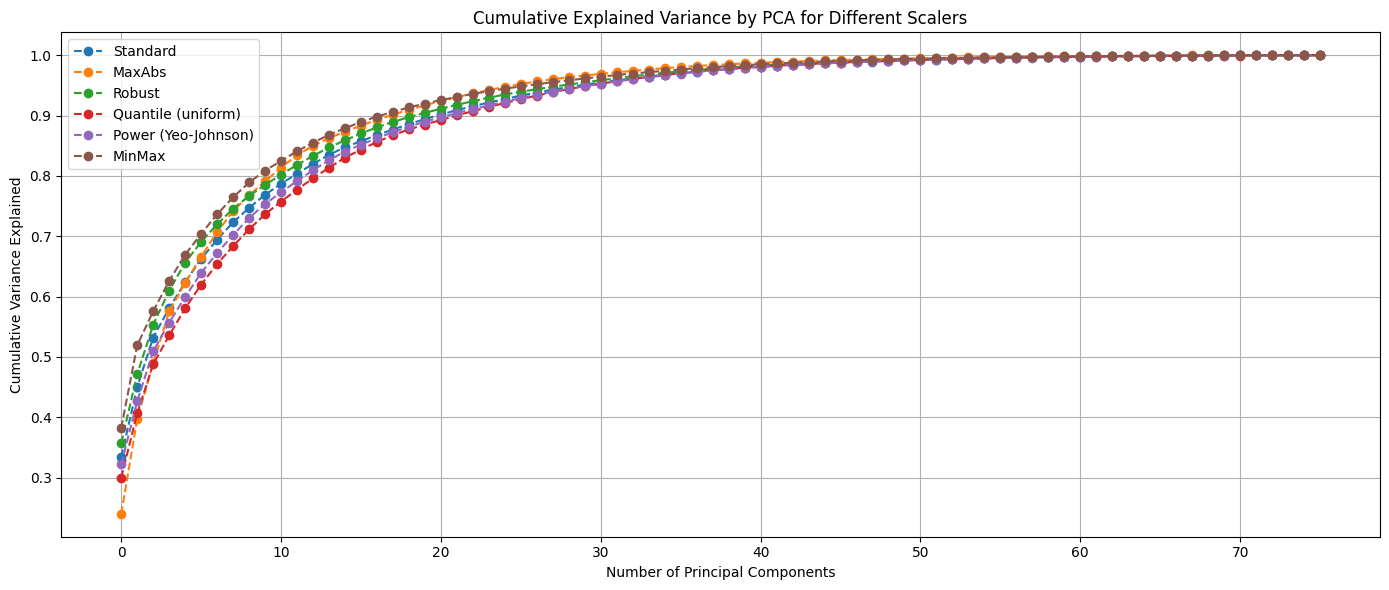

In [467]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Prepare scalers in a dict for easy iteration
scalers = {
    "Standard": StandardScaler(),
    "MaxAbs": MaxAbsScaler(),
    "Robust": RobustScaler(),
    "Quantile (uniform)": QuantileTransformer(output_distribution='uniform', random_state=0),
    "Power (Yeo-Johnson)": PowerTransformer(method='yeo-johnson'),
    "MinMax": MinMaxScaler(),
}

# Store cumulative variance per scaler
cum_variances = {}

for name, scaler in scalers.items():
    try:
        scaled = scaler.fit_transform(df_stationary)
        pca = PCA()
        X_pca = pca.fit_transform(scaled)
        cum_var = np.cumsum(pca.explained_variance_ratio_)
        cum_variances[name] = cum_var
    except Exception as e:
        print(f"Skipping {name} due to error: {e}")

# Plot all in one figure
plt.figure(figsize=(14, 6))

for name, cum_var in cum_variances.items():
    plt.plot(cum_var, marker='o', linestyle='--', label=name)

plt.title("Cumulative Explained Variance by PCA for Different Scalers")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


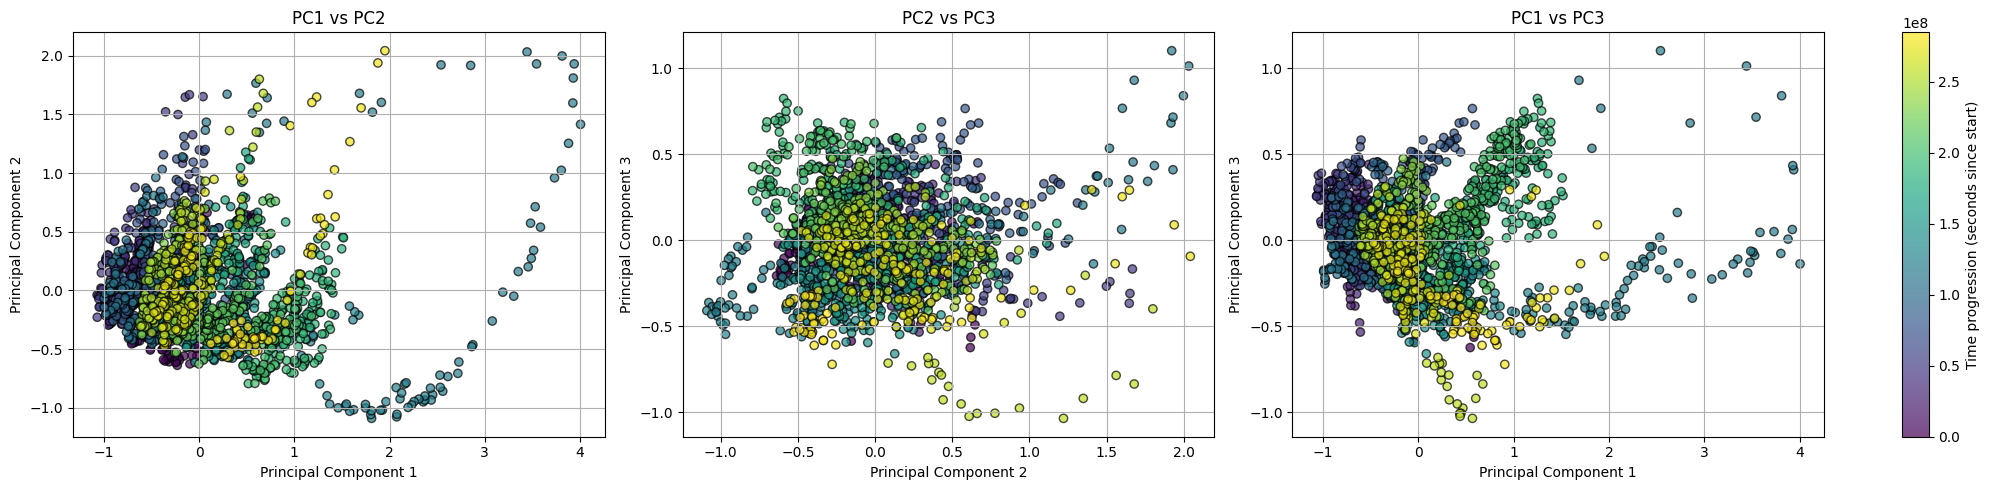

In [468]:
import matplotlib.gridspec as gridspec

# Convert timestamps to numeric
timestamps = pd.to_datetime(df_pivot_clean.index)
time_numeric = (timestamps - timestamps.min()).total_seconds()

# Set up figure with gridspec
fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])  # Last column for colorbar

# Common colormap
cmap = plt.cm.viridis

# Plot 1: PC1 vs PC2
ax0 = plt.subplot(gs[0])
sc0 = ax0.scatter(X_pca[:, 0], X_pca[:, 1], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax0.set_title("PC1 vs PC2")
ax0.set_xlabel("Principal Component 1")
ax0.set_ylabel("Principal Component 2")
ax0.grid(True)

# Plot 2: PC2 vs PC3
ax1 = plt.subplot(gs[1])
sc1 = ax1.scatter(X_pca[:, 1], X_pca[:, 2], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax1.set_title("PC2 vs PC3")
ax1.set_xlabel("Principal Component 2")
ax1.set_ylabel("Principal Component 3")
ax1.grid(True)

# Plot 3: PC1 vs PC3
ax2 = plt.subplot(gs[2])
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 2], c=time_numeric, cmap=cmap, alpha=0.7, edgecolors='k')
ax2.set_title("PC1 vs PC3")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 3")
ax2.grid(True)

# Add a colorbar in the dedicated subplot
cax = plt.subplot(gs[3])
cb = plt.colorbar(sc2, cax=cax)
cb.set_label("Time progression (seconds since start)")

plt.tight_layout()
plt.show()


In [437]:
df_adj.columns

Index(['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count',
       'vwap', 'atr_norm_5', 'atr_norm_20', 'atr_norm_60', 'log_returns',
       'z_range_ratio_smooth', 'z_log_returns', 'vol_shock_count_20',
       'z_rolling_std_5', 'z_rolling_std_20', 'z_rolling_std_60',
       'volatility_dispersion'],
      dtype='object')

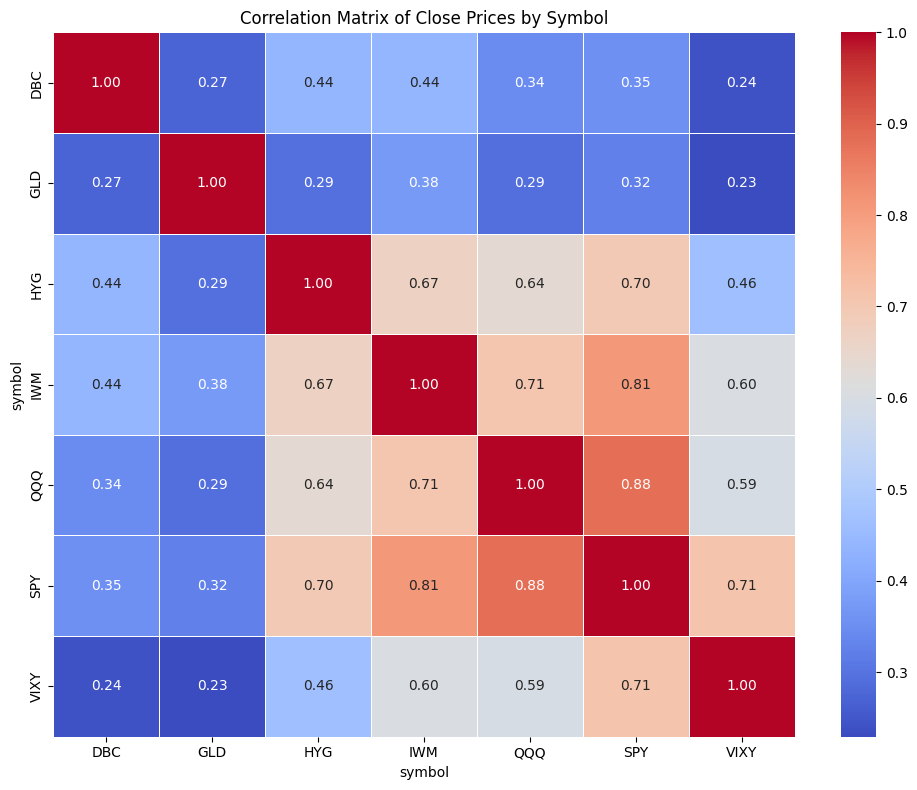

In [466]:
## BUSCAR UN GRUPO QUE NO TENGA UNA CORRELACION ALTA?????

# # # ##### Correlation Heatmap #####
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot 'Close' prices by symbol; index is already datetime
pivot_df = df_adj.pivot(columns='symbol', values='z_rolling_std_20')

# Optionally drop rows with missing values to ensure clean correlation
pivot_df = pivot_df.dropna()

# Compute the correlation matrix
correlation_matrix = pivot_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Close Prices by Symbol")
plt.tight_layout()
plt.show()


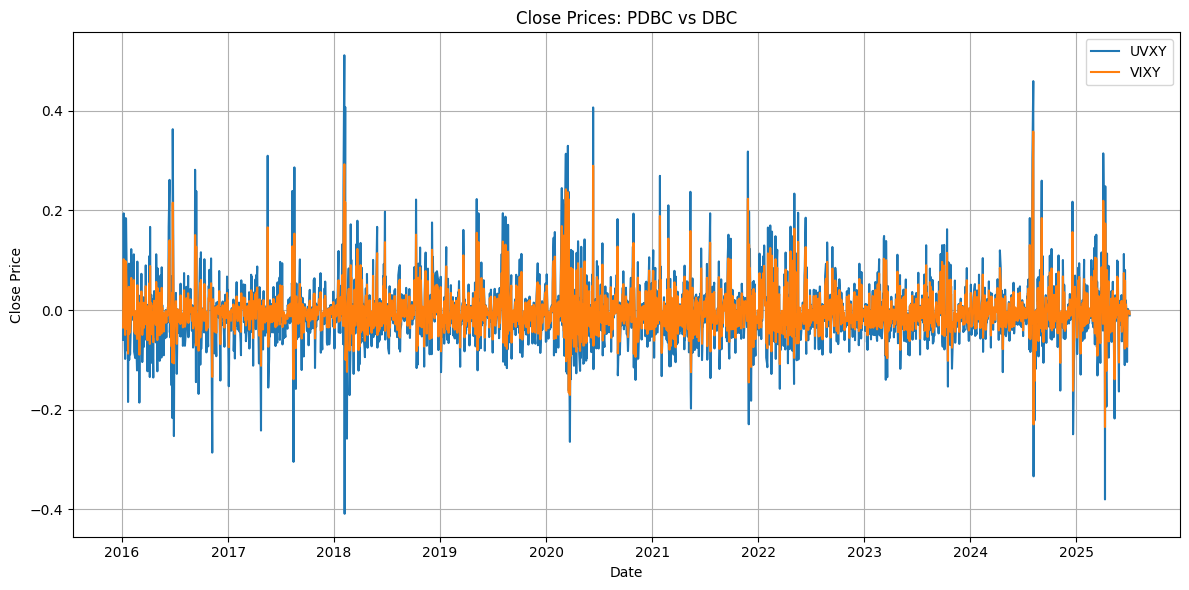

In [433]:
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

for symbol in ['UVXY', 'VIXY']:
    subset = df_adj[df_adj['symbol'] == symbol]
    ax.plot(subset.index, subset['log_returns'], label=symbol)

ax.set_title('Close Prices: PDBC vs DBC')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
